## [1] sklearn.ensemble.RandomForestClassifier 

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

X, y = make_classification(n_samples=500,
                           n_features=25,
                           n_clusters_per_class=1,
                           n_informative=15,
                           random_state=123)

In [2]:
ensemble_clfs = [(0, "max_features = 'sqrt'",
                  RandomForestClassifier(warm_start=True,
                                         oob_score=True,
                                         max_features="sqrt",
                                         random_state=123)),
                 (1, "max_features = 'log2'",
                  RandomForestClassifier(warm_start=True,
                                         max_features="log2",
                                         oob_score=True,
                                         random_state=123)),
                 (2, "max_features = None",
                  RandomForestClassifier(warm_start=True,
                                         max_features=None,
                                         oob_score=True,
                                         random_state=123))] 

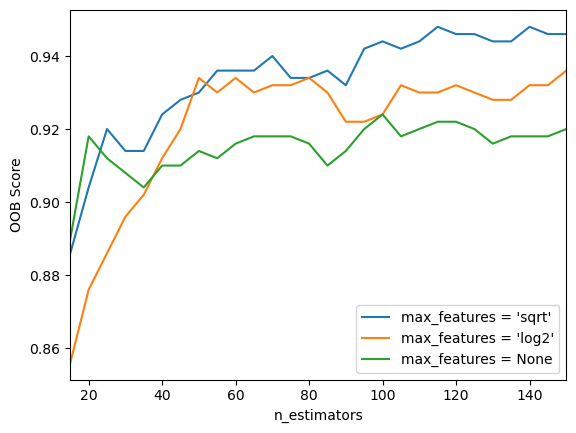

In [3]:
min_estimators = 15
max_estimators = 150

oob_scores = [[], [], []]

for ind, label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)    ## parameter 설정 
        clf.fit(X, y)
        oob_scores[ind].append((i, clf.oob_score_))

for i in range(len(ensemble_clfs)):
    xs, ys = zip(*oob_scores[i])
    plt.plot(xs, ys, label=ensemble_clfs[i][1])

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB Score")
plt.legend(loc="best")

## [2] 피처 중요도

In [4]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_classes=2,
                           random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [6]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)   #forst.estimators_: 각 의사결정트리들의 list,   tree.feature_importances_ 트리에서 각 피처의 중요도 계산

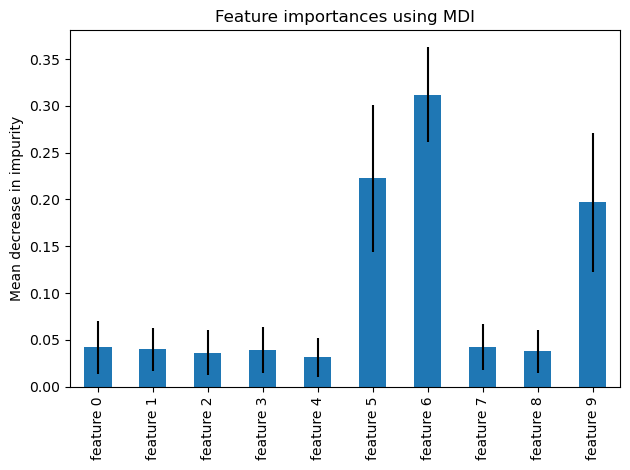

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax) # yerr는 오차막대를 위해 표준편차를 입력함
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest,
                                X_test,
                                y_test,
                                n_repeats=10,
                                random_state=0)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

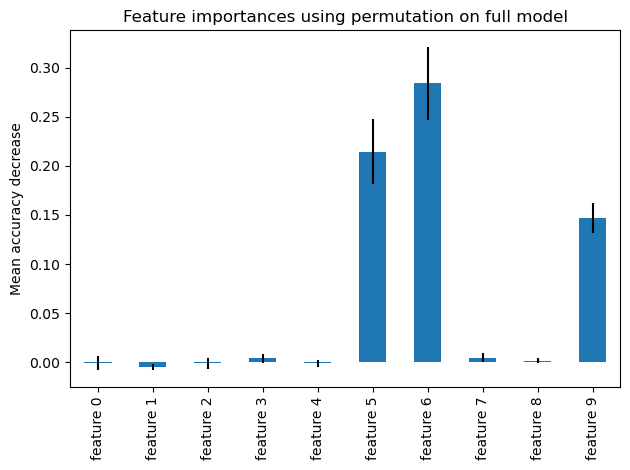

In [13]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importances using permutation on full model')
ax.set_ylabel('Mean accuracy decrease')
fig.tight_layout()
plt.show()

## [3] GridSearchCV 로 n_estimators와 max_features 튜닝하기 (트리개수와 피처배깅 옵션 튜닝하기)

In [35]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.iloc[0, 0] = np.nan
X.iloc[1, 0] = np.nan
X.iloc[2, 2] = np.nan
X.iloc[3, 4] = np.nan
X.iloc[4, 3] = np.nan
X.iloc[5, 1] = np.nan
X.iloc[5, 2] = np.nan


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=1234)

In [36]:
n_estimators = list(np.arange(10,160,10))
max_features=['sqrt','log2',None]

In [37]:
pipeline=Pipeline(steps=[('imputer',SimpleImputer()),('scaler',StandardScaler()),('basemodel',RandomForestClassifier(warm_start=True,
                                         random_state=123))])
param_grid={'basemodel__n_estimators':n_estimators,'basemodel__max_features':max_features}
kfold=KFold(n_splits=4, shuffle=True, random_state=1234) 

In [38]:
grid_search=GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold )     
grid_search.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('basemodel',
                                        RandomForestClassifier(random_state=123,
                                                               warm_start=True))]),
             param_grid={'basemodel__max_features': ['sqrt', 'log2', None],
                         'basemodel__n_estimators': [10, 20, 30, 40, 50, 60, 70,
                                                     80, 90, 100, 110, 120, 130,
                                                     140, 150]})

In [41]:
print('최적 n_estimators:',grid_search.best_params_['basemodel__n_estimators'])
print('최적 max_features:',grid_search.best_params_['basemodel__max_features'])
print('최적 모델의 accuracy', grid_search.best_score_)

최적 n_estimators: 30
최적 max_features: sqrt
최적 모델의 accuracy 0.9718083230470815


In [42]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report
y_pred = grid_search.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90        55
           1       0.91      0.99      0.95        88

    accuracy                           0.93       143
   macro avg       0.94      0.91      0.92       143
weighted avg       0.93      0.93      0.93       143



## [4] RandomForestRegressor

In [43]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)

In [49]:
reg=RandomForestRegressor(warm_start=True,
                                         oob_score=True,
                                         max_features="sqrt",
                                         random_state=123)
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
print(f'학습 데이터셋 MAE:{(np.abs(y_pred_train - y_train)).mean(): .2f}')
print(f'학습 데이터셋 R2:{reg.score(X_train,y_train): .2f}')



y_pred = reg.predict(X_test)
print(f'테스트 데이터셋 MAE:{(np.abs(y_pred - y_test)).mean(): .2f}')
print(f'테스트 데이터셋 R2:{reg.score(X_test,y_test): .2f}')
print(f'OOB R2:{reg.oob_score_: .2f}')

학습 데이터셋 MAE: 18.04
학습 데이터셋 R2: 0.92
테스트 데이터셋 MAE: 44.66
테스트 데이터셋 R2: 0.49
OOB R2: 0.39


In [50]:
reg.oob_prediction_

array([141.16216216, 178.5483871 , 100.25641026, 108.23684211,
       111.62068966, 199.63888889, 218.25      , 187.65      ,
       135.1875    , 196.20512821,  72.16216216, 109.16666667,
       108.06666667, 151.9047619 , 198.81818182, 264.03225806,
       127.425     , 161.65789474, 130.53846154,  88.15      ,
       111.58695652, 133.27906977, 199.35897436, 247.75675676,
       125.02564103, 131.94444444, 176.4375    , 257.2       ,
       184.2       , 146.28205128, 172.97560976, 109.60606061,
        79.14285714, 126.82352941,  79.61538462, 262.85714286,
       123.28125   ,  97.03703704, 131.42424242, 116.46938776,
       112.82222222, 170.67857143, 159.68888889, 144.60869565,
        79.36666667, 144.25641026, 113.38297872, 181.82222222,
        85.14285714, 166.075     , 126.5       , 154.97297297,
       106.79069767, 178.89473684,  85.90243902, 135.07692308,
       152.06451613,  90.53125   , 163.5       ,  91.        ,
       206.97435897, 160.48837209, 162.92592593, 248.32